In [9]:
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import ephem

In [14]:
filters=['g','r','i','z','VR']

colormaps={'g': plt.cm.Greens,
           'r': plt.cm.Oranges,
           'i': plt.cm.Purples,
           'z': plt.cm.Greys,
           'VR': plt.cm.Blues}

In [37]:
def make_exp_map(data_file='decam_exposures_i_min30sec_Sep2016.csv',
                 title='DECam i-band sky coverage as of September 2016',
                 color=plt.cm.Purples,
                 band=None,
                 out_file='test.pdf',
                 ra_in_degrees=True,
                 width_of_mw_band=10.):

    data = ascii.read(data_file,header_start=0)

    if band == None:
        ra = coord.Angle(data['ra']*u.degree)
        dec = coord.Angle(data['dec']*u.degree)
        exptime = data['exptime']
    else:
        idx = data['band'] == band
        ra = coord.Angle(data[idx]['ra']*u.degree)
        dec = coord.Angle(data[idx]['dec']*u.degree)
        exptime = data[idx]['exptime']
    
    ra = ra.wrap_at(180*u.degree)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="mollweide")
    npix_ra=360/6 
    hb=ax.hexbin(ra.radian, dec.radian, C=exptime, gridsize=npix_ra, bins='log',
                 reduce_C_function=np.sum,cmap=color)
    cb=fig.colorbar(hb,orientation='horizontal',cax=fig.add_axes([0.2, 0.17, 0.6, 0.03]))
    cb.set_label('total exposure [log (exptime/sec)]')
    ax.set_title(title+'\n')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    if not ra_in_degrees:
        ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
    ax.grid(True)

    ra_MW, dec_MW = the_galaxy_in_equatorial_coords(width_of_mw_band)
    for i in range(len(ra_MW)):
        ra = coord.Angle(ra_MW[i]*u.degree)
        ra = ra.wrap_at(180*u.degree)        
        dec = coord.Angle(dec_MW[i]*u.degree)
        slices = unlink_wrap(ra.radian)
        for slc in slices:
            ax.plot(ra.radian[slc],dec.radian[slc],'b',lw=2)        

#    ra_fields_hours={'F1': 10, 'F2': 16, 'F3': 22}
#    ra_fields_degrees={'F1': 150, 'F2': -120, 'F3': -30}
#    dec_fields_degrees={'F1': -15, 'F2': -15, 'F3': -15}
#    ra_fields = np.array([150.,-120.,-30.])
#    dec_fields = np.array([-15.,-15.,-15.])
#    ra = coord.Angle(ra_fields*u.degree)
#    ra = ra.wrap_at(180*u.degree)
#    dec = coord.Angle(dec_fields*u.degree)
#    ax.scatter(ra.radian,dec.radian,s=100,color='red',marker='D')

    fig.savefig(out_file)
    fig.show()

In [4]:
def the_galaxy_in_equatorial_coords(width=0.):
    lon_array = np.arange(0,360)
    ra, dec = [] , []
    lat_list = [ -0.5*width, 0. , 0.5*width]
    for lat in lat_list:
        eq_array = np.zeros((360,2))
        for lon in lon_array:
            ga = ephem.Galactic(np.radians(lon), np.radians(lat))
            eq = ephem.Equatorial(ga)
            eq_array[lon] = np.degrees(eq.get())
        ra.append(eq_array[:,0])
        dec.append(eq_array[:,1])
    return ra,dec

In [5]:
def unlink_wrap(dat, lims=[-np.pi, np.pi], thresh = 0.95):
    """
    Iterate over contiguous regions of `dat` (i.e. where it does not
    jump from near one limit to the other).

    This function returns an iterator object that yields slice
    objects, which index the contiguous portions of `dat`.

    This function implicitly assumes that all points in `dat` fall
    within `lims`.

    """    
    jump = np.nonzero(np.abs(np.diff(dat)) > ((lims[1] - lims[0]) * thresh))[0]
    lasti = 0
    for ind in jump:
        yield slice(lasti, ind + 1)
        lasti = ind + 1
    yield slice(lasti, len(dat))

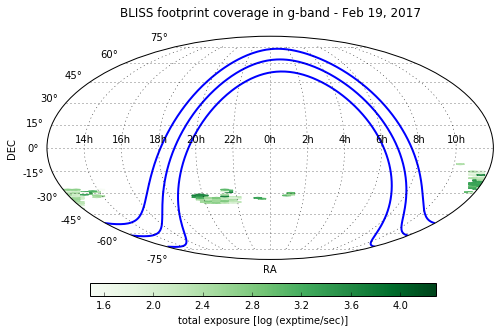

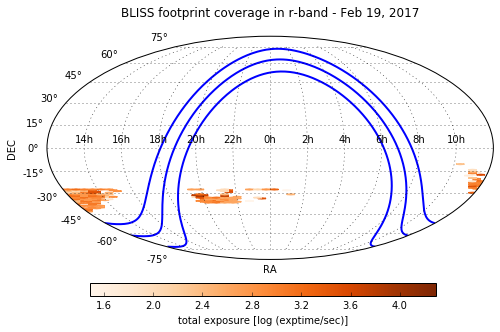

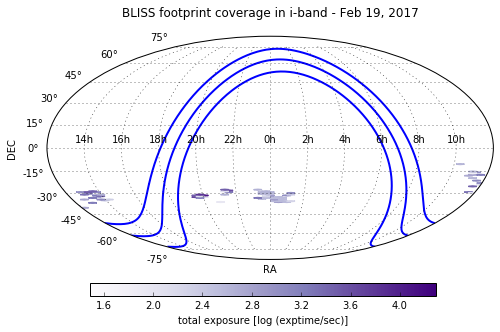

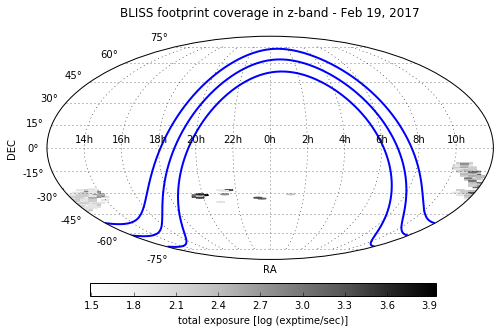

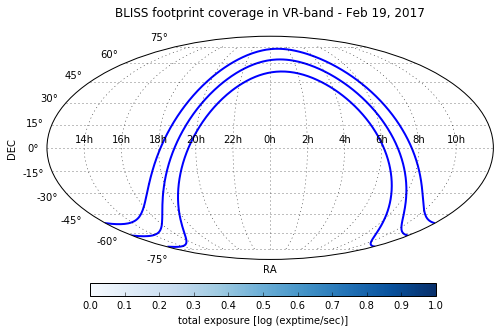

In [38]:
for b in filters:
    make_exp_map(data_file='bliss_exposures_v0.csv',
                 title='BLISS footprint coverage in '+b+'-band - Feb 19, 2017',
                 color=colormaps[b],
                 band=b,
                 out_file='bliss_v0_'+b+'.pdf',
                 ra_in_degrees=False,
                 width_of_mw_band=20.)